In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [45]:
df =  pd.read_csv('2yrs_data.csv')

In [46]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('Datetime')
data = df['Global_active_power'].values.reshape(-1, 1)

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [48]:

class MultiStepTimeSeriesGenerator():
    """
    Copied and edited from https://www.tensorflow.org/tutorials/structured_data/time_series
    """
    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 df,
                 batch_size):

        # Work out the window parameters.
        self.input_width       = input_width
        self.label_width       = label_width
        self.shift             = shift
        self.batch_size        = batch_size
        self.total_window_size = input_width + label_width
        self.input_slice       = slice(0, input_width)
        self.labels_slice      = slice(self.total_window_size - self.label_width, None)
        
        # Preprocess the raw data into datasets
        val_split = 0.2
        self.train_df = df[0:int((len(df)-N_STEPS_OUT)*(1-val_split))]
        self.val_df = df[int((len(df)-N_STEPS_OUT)*(1-val_split))-N_STEPS_IN:-N_STEPS_OUT]
        self.test_df = df[-(N_STEPS_IN + N_STEPS_OUT):]

        self.train = self.make_dataset(self.train_df)
        self.val   = self.make_dataset(self.val_df)
        self.test  = self.make_dataset(self.test_df)

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        labels = tf.stack([labels[:, :, 0]], axis = -1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data            = data,
                                                          targets         = None,
                                                          sequence_length = self.total_window_size,
                                                          sequence_stride = 1,
                                                          shuffle         = False,
                                                          batch_size      = self.batch_size)

        ds = ds.map(self.split_window)

        return ds



In [49]:
N_STEPS_IN = 24
N_STEPS_OUT = 24
N_EPOCHS = 20   
BATCH_SIZE = 64
time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                                   label_width = N_STEPS_OUT, 
                                                   shift       = 1, 
                                                   df          = data_scaled, 
                                                   batch_size  = BATCH_SIZE)

In [50]:
def plot_loss_and_predictions(y_pred, history, n_epochs, feature_df):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training/validation loss
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot predictions against actual values
    y_actual = feature_df[-len(y_pred):]  # Match size of predictions
    ax[1].plot(y_actual.index, y_actual.values, label='Actual', color='blue')
    ax[1].plot(y_actual.index, y_pred.reshape(-1), label='Predicted', color='red')
    ax[1].set_title('Predictions vs Actual')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    return ax

def evaluate_baseline(model, df, n_epochs = N_EPOCHS, verbose = 0):
    # Compile model
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])
    
    # Create datasets from dataframe
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                              label_width = N_STEPS_OUT, 
                                              shift       = 1, 
                                              df          = df, 
                                              batch_size  = BATCH_SIZE)

    # Train model
    history = model.fit(time_series_dataset.train, 
                        validation_data = time_series_dataset.val,
                        epochs          = n_epochs,
                        batch_size      = BATCH_SIZE, 
                        verbose         = verbose, 
                        callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                           patience = 4),
                        shuffle         = False)

    # Make predictions on test set
    y_pred = model.predict(time_series_dataset.test, verbose=0)
    test_score = mean_squared_error(list(time_series_dataset.test.as_numpy_iterator())[0][1][0], y_pred.reshape(-1))
    test_score = np.round(test_score, 5)
    
    # Plot predictions
    ax = plot_loss_and_predictions(y_pred, history, n_epochs, df[['feature']])

    return test_score, ax



In [51]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),
    LSTM(32, activation='relu'),
    Dense(N_STEPS_OUT) 
])

# Compile model
model.compile(loss      = tf.losses.MeanSquaredError(),
              optimizer = tf.optimizers.Adam(),
              metrics   = [tf.metrics.MeanAbsoluteError()])

# Create datasets from dataframe
time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                          label_width = N_STEPS_OUT, 
                                          shift       = 1, 
                                          df          = data_scaled, 
                                          batch_size  = BATCH_SIZE)
# Train model
history = model.fit(time_series_dataset.train, 
                    validation_data = time_series_dataset.val,
                    epochs          = N_EPOCHS,
                    batch_size      = BATCH_SIZE, 
                    verbose         = 1, 
                    callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                       patience = 4),
                    shuffle         = False)

# Make predictions on test set
y_pred = model.predict(time_series_dataset.test, verbose=0)
test_score = mean_squared_error(list(time_series_dataset.test.as_numpy_iterator())[0][1][0], y_pred.reshape(-1))
test_score = np.round(test_score, 5)

print(f"Test Mean Squared Error: {test_score}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13382/13382 ━━━━━━━━━━━━━━━━━━━━ 113s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0458 - val_loss: 0.0037 - val_mean_absolute_error: 0.0380
Epoch 2/20
13382/13382 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0380 - val_loss: 0.0035 - val_mean_absolute_error: 0.0358
Epoch 3/20
13382/13382 ━━━━━━━━━━━━━━━━━━━━ 128s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0375 - val_loss: 0.0034 - val_mean_absolute_error: 0.0349
Epoch 4/20
13382/13382 ━━━━━━━━━━━━━━━━━━━━ 132s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0372 - val_loss: 0.0034 - val_mean_absolute_error: 0.0347
Epoch 5/20
13382/13382 ━━━━━━━━━━━━━━━━━━━━ 131s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0369 - val_loss: 0.0034 - val_mean_absolute_error: 0.0347
Epoch 6/20
13382/13382 ━━━━━━━━━━━━━━━━━━━━ 130s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0367 - val_loss: 0.0034 - val_mean_absolute_error: 0.0345
Epoch 7/20
13382/13382 ━━━━━━━━━━━━━━━━━━━━ 140s 10ms/step - loss: 0.0

2024-11-23 18:53:58.759143: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


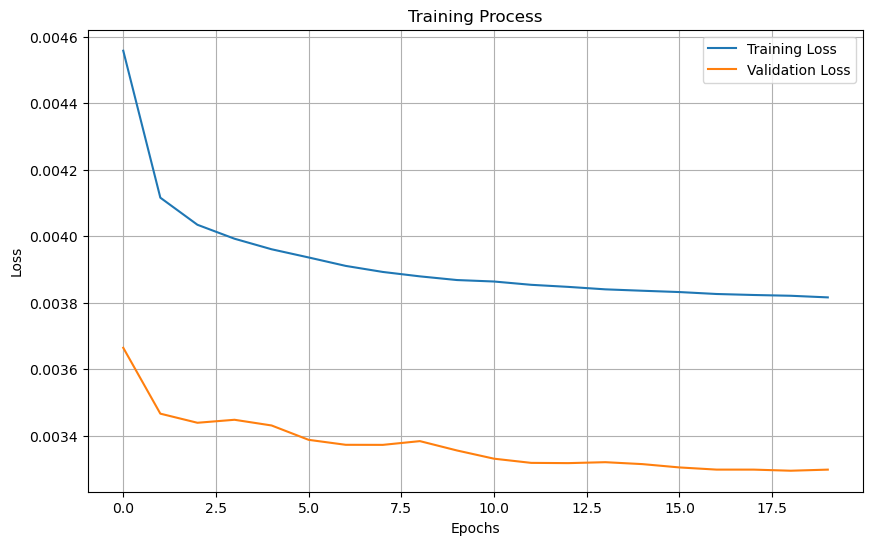

In [52]:
# Extract training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Process')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
